In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy

# 1 数据集处理

## 1.1 检验源数据集正确性

In [2]:
# 读入label中的每一条信息，并添加地址
def load_metadata(folder_list):
    tmp_lines = []
    res_lines = []
    for folder_name in folder_list:
        folder = os.path.join('data', folder_name)
        metadata_file = os.path.join(folder, 'label.txt')
        with open(metadata_file) as f:
            lines = f.readlines()
        tmp_lines.extend(list(map((folder + '\\').__add__, lines)))
    for line in tmp_lines:
        name = line.split()[0]
        if os.path.isfile(name):
            res_lines.append(line)
    return res_lines

In [3]:
# 将一行原始信息处理成{‘图片地址’：[(边框1，关键点1),(边框2，关键点2)...]}
def load_truth(lines):
    truth = {}
    for line in lines:
        line = line.strip().split()
        name = line[0]
        if name not in truth:
            truth[name] = []
        rect = list(map(int, list(map(float, line[1:5]))))
        x = list(map(float, line[5::2]))
        y = list(map(float, line[6::2]))
        landmarks = list(zip(x, y))
        truth[name].append((rect, landmarks))
    return truth

In [4]:
# 将显示框线的四个值转换为坐标点
def rect_trans(rect):
    r_x = np.array([rect[0],rect[0],rect[2],rect[2],rect[0]])
    r_y = np.array([rect[1],rect[3],rect[3],rect[1],rect[1]])
    return r_x,r_y

In [5]:
# 显示指定图片,data为经过处理后的数据信息
def key_show(key,data):
    img = plt.imread(key)
    fig = plt.figure(figsize=(10,10))
    ax = fig.subplots()
    ax.axis('off')
    ax.imshow(img)
    for i in range(len(data[key])):
        rect = data[key][i][0]
        landmarks = np.array(data[key][i][1])
        r_x,r_y = rect_trans(rect)
        ax.plot(r_x,r_y,color='g',linewidth=2)
        ax.scatter(landmarks[:,0],landmarks[:,1],s=5,c='r')
    plt.show()
    
# 随机显示图片
def check_show(data):
    names = []
    for key in data:
        if key not in names:
            names.append(key)
    index = np.random.randint(0,len(names))
    name = names[index]
    key_show(name,data)

In [6]:
#data 中的两个折叠列表！
folder_list = ['I', 'II']
res_lines = load_metadata(folder_list)
truth = load_truth(res_lines)

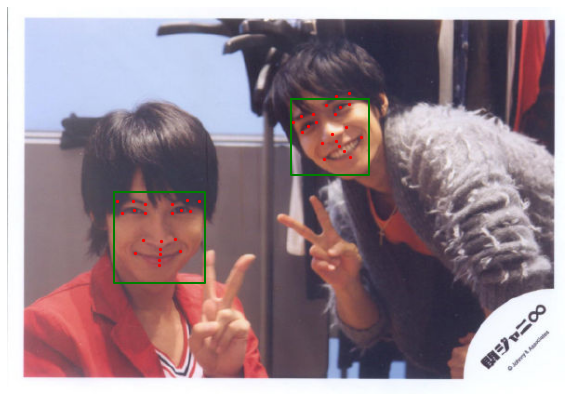

In [15]:
check_show(truth)

## 1.2 扩大人脸框范围

In [16]:
# 将人脸框扩大（默认0.25倍）；保证人脸框不超过图像大小
def expand_roi(rect, img_width, img_height, ratio=0.25):
    # 扩大框
    x1, y1, x2, y2 = rect[0],rect[1],rect[2],rect[3]
    width = x2 - x1 + 1
    height = y2 - y1 + 1
    padding_width = int(width * ratio)
    padding_height = int(height * ratio)
    x1 = x1 - padding_width
    y1 = y1 - padding_height
    x2 = x2 + padding_width
    y2 = y2 + padding_height
    # 保证不超过图像
    x1 = 0 if x1 < 0 else x1
    y1 = 0 if y1 < 0 else y1
    x2 = img_width - 1 if x2 >= img_width else x2
    y2 = img_height - 1 if y2 >= img_height else y2 
    rect[0],rect[1],rect[2],rect[3] = x1, y1, x2, y2

In [17]:
def change_data_rect(data):
    for key in data:
        img = plt.imread(key)
        img_h,img_w = img.shape[:2]
        value = data[key]
        for i in range(len(value)):
            expand_roi(value[i][0],img_w,img_h)
    return data

In [18]:
# 先深度拷贝再进行函数处理，避免原数据更改，便于调试
data_change_rect = copy.deepcopy(truth)
data_change_rect = change_data_rect(data_change_rect)

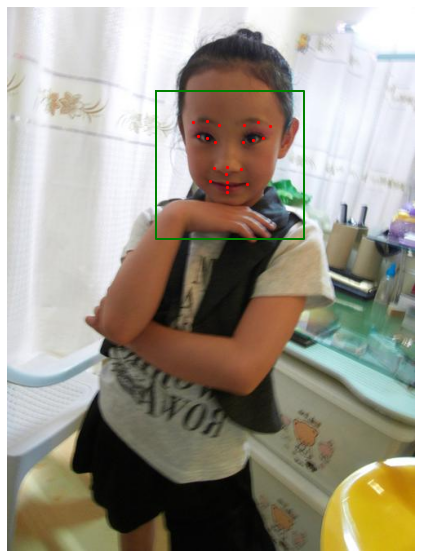

In [20]:
check_show(data_change_rect)

In [21]:
# 检验扩增效果
def compare_show(data1,data2):
    names = []
    for key in data1:
        if key not in names:
            names.append(key)
    index = np.random.randint(0,len(names))
    name = names[index]
    key_show(name,data1)
    key_show(name,data2)

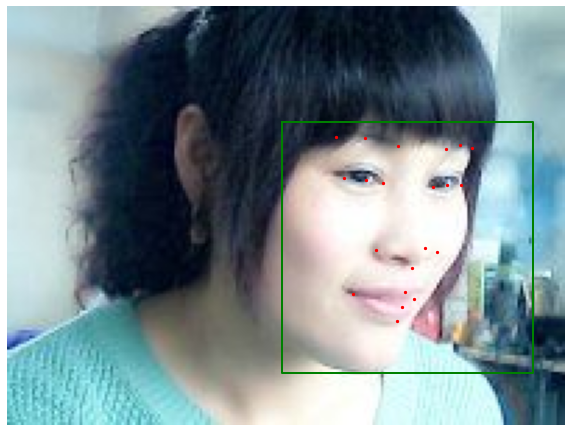

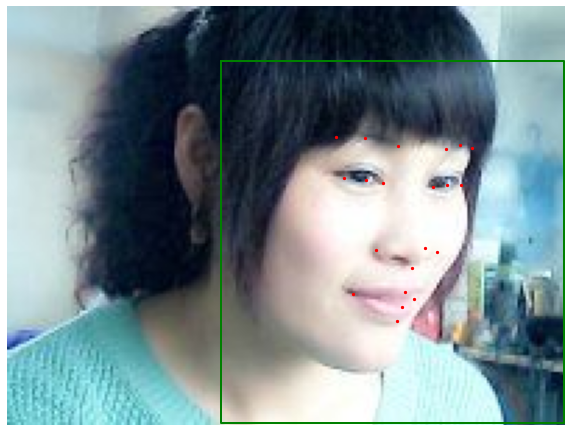

In [24]:
compare_show(truth,data_change_rect)

## 1.3 关键点坐标变更

In [25]:
# 人脸关键点坐标变更 landmarks -= np.array([roi x1,roi y1])
def change_data_landmarks(data):
    delete_value1 = {}
    delete_value2 = {}
    delete_key = []
    for key in data:
        value = data[key]
        deletes1 = []
        deletes2 = []
        for i in range(len(value)):
            r = np.array([value[i][0][0],value[i][0][1]])
            w = value[i][0][2] - value[i][0][0]
            h = value[i][0][3] - value[i][0][1]
            for j in range(len(value[i][1])):
                value[i][1][j] -= r
                if value[i][1][j][0]<0 or value[i][1][j][1]<0:
                    deletes1.append(value[i])
                    break
                if value[i][1][j][0]>w or value[i][1][j][1]>h:
                    deletes2.append(value[i])
                    break
        if len(deletes1) != 0:
            delete_value1[key] = []
            for delete in deletes1:
                value.remove(delete)
                delete_value1[key].append(delete)
        if len(deletes2) != 0:
            delete_value2[key] = []
            for delete in deletes2:
                value.remove(delete)
                delete_value2[key].append(delete)
        if len(value) == 0:
            delete_key.append(key)
    for key in delete_key:
        del data[key]
            
    return data,delete_value1,delete_value2

In [26]:
# 先深度拷贝再进行函数处理，避免原数据更改，便于调试
data_change_landmarks = copy.deepcopy(data_change_rect)
data_change_landmarks,delete_value1,delete_value2 = change_data_landmarks(data_change_landmarks)

In [27]:
len(data_change_landmarks),len(delete_value1),len(delete_value2)

(1947, 44, 25)

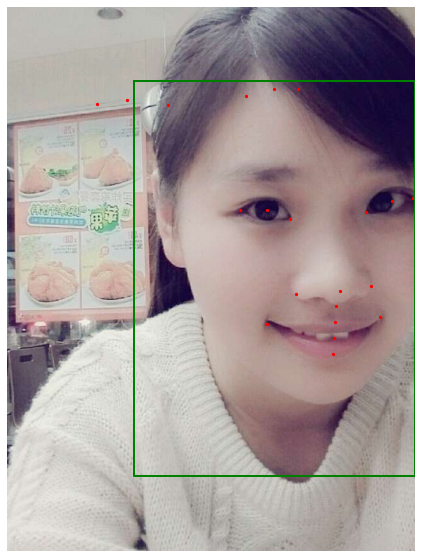

In [29]:
# 查看删除样本情况
check_show(delete_value2)

## 1.4 生成train/test.txt

In [30]:
# 数据类型转换
def trans_value(key,value):
    rect = ''
    for r in value[0]:
        rect += ' ' + str(r)
    landmarks = ''
    for lms in value[1]:
        landmark = ''
        for lm in lms:
            landmark += ' ' + str(lm)
        landmarks += landmark
    line = line = key+rect+landmarks
    return line

In [31]:
# 样本个数train：test=8:2，即train有1570个，test有392个
def gen_data(data,rate=4):
    lines = []
    for key in data:
        values = data[key]
        for i in range(len(values)):
            line = trans_value(key,values[0])
            lines.append(line)
            values.remove(values[0])
    number = len(lines)
    train = lines[:int(number*(4/5))]
    test = lines[int(number*(4/5)):]
    return train,test,lines

In [32]:
data = copy.deepcopy(data_change_landmarks)
train,test,lines = gen_data(data)
len(train),len(test),len(lines)

(2173, 544, 2717)

In [33]:
# 输出train/test.txt文件
def write_txt(data,path):
    with open(path,"w") as f:
        for d in data:
            f.write(d + '\n')
    print('File %s is ready!'%path)

In [34]:
write_txt(train,"data\\train.txt")
write_txt(test,"data\\test.txt")

File data\train.txt is ready!
File data\test.txt is ready!


## 1.5 验证数据正确性

In [35]:
# 读取生成的数据
def load_data(path):
    lines = []
    with open(path) as f:
        lines = f.readlines()
    data = load_truth(lines)
    return data

In [49]:
train = load_data("data\\train.txt")
len(train)

1421

In [46]:
# 随机选取样本画图
def data_show(data):
    # 随机选取
    names = []
    for key in data:
        names.append(key)
    index = np.random.randint(0,len(names))
    name = names[index]
    data_key_show(name,data)
    
def data_key_show(key,data):
    # 读取原图像
    img = plt.imread(key)
    value = data[key]
    num = len(value)
    fig = plt.figure(figsize=(10,10))
    axes = fig.subplots(nrows=1,ncols=num)
    for i in range(num):
        # 画出截图头像
        crop = value[i][0]
        crop_img = img[crop[1]:crop[3],crop[0]:crop[2]]
        if num == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(crop_img)
        # 画出关键点
        landmarks = np.array(value[i][1])
        ax.scatter(landmarks[:,0],landmarks[:,1],s=5,c='r')
    plt.show

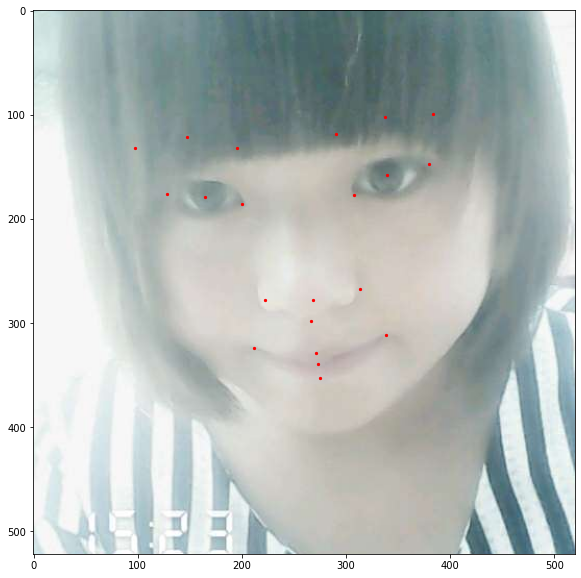

In [48]:
data_show(train)